In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        """
        Define the layers of the convolutional neural network.

        Parameters:
            in_channels: int
                The number of channels in the input image. For MNIST, this is 1 (grayscale images).
            num_classes: int
                The number of classes we want to predict, in our case 10 (digits 0 to 9).
        """
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 8 output channels (filtros), 3x3 kernel, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Fully connected layer: 16*7*7 input features (after two 2x2 poolings), 10 output features (num_classes)
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: torch.Tensor
                The input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
input_size = 784  # 28x28 pixels (not directly used in CNN)
num_classes = 10  # digits 0-9
learning_rate = 0.001
batch_size = 64
num_epochs = 10  # Reduced for demonstration purposes

In [6]:
train_dataset = datasets.MNIST(root="dataset/", download=True, train=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root="dataset/", download=True, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.00MB/s]


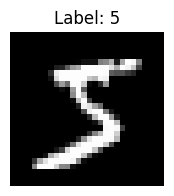

In [7]:
import matplotlib.pyplot as plt

# Get the first image and label from the training dataset
image, label = train_dataset[0]

# Permute the dimensions of the image tensor to (height, width, channels) for plotting
image = image.permute(1, 2, 0)

# Set the figure size to make the image smaller (e.g., 2x2 inches)
plt.figure(figsize=(2, 2))

# Plot the image
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')  # Hide the axes
plt.show()

In [8]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        # Move data and targets to the device (GPU/CPU)
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass: compute the model output
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass: compute the gradients
        optimizer.zero_grad()
        loss.backward()

        # Optimization step: update the model parameters
        optimizer.step()

Epoch [1/10]


100%|██████████| 938/938 [00:24<00:00, 38.66it/s]


Epoch [2/10]


100%|██████████| 938/938 [00:23<00:00, 39.59it/s]


Epoch [3/10]


100%|██████████| 938/938 [00:28<00:00, 33.04it/s]


Epoch [4/10]


100%|██████████| 938/938 [00:23<00:00, 40.42it/s]


Epoch [5/10]


100%|██████████| 938/938 [00:23<00:00, 39.42it/s]


Epoch [6/10]


100%|██████████| 938/938 [00:23<00:00, 40.25it/s]


Epoch [7/10]


100%|██████████| 938/938 [00:23<00:00, 39.20it/s]


Epoch [8/10]


100%|██████████| 938/938 [00:22<00:00, 41.23it/s]


Epoch [9/10]


100%|██████████| 938/938 [00:23<00:00, 39.21it/s]


Epoch [10/10]


100%|██████████| 938/938 [00:23<00:00, 40.34it/s]


In [11]:
def check_accuracy(loader, model):
    """
    Checks the accuracy of the model on the given dataset loader.

    Parameters:
        loader: DataLoader
            The DataLoader for the dataset to check accuracy on.
        model: nn.Module
            The neural network model.
    """
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass: compute the model output
            scores = model(x)
            _, predictions = scores.max(1)  # Get the index of the max log-probability
            num_correct += (predictions == y).sum()  # Count correct predictions
            num_samples += predictions.size(0)  # Count total samples

        # Calculate accuracy
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")

    model.train()  # Set the model back to training mode

In [12]:
# Final accuracy check on training and test sets
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Checking accuracy on training data
Got 59508/60000 with accuracy 99.18%
Checking accuracy on test data
Got 9853/10000 with accuracy 98.53%


Ejercicios:
1) Graficar learning curves.
2) Comparar performance para distinto número de capas convolucionales.
3) Preprocesar el input para que las imagenes sean 1 o 0 (blanco o negro, no gris).